# Hi Split
A five-minute tutorial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lohi_splitter as lohi

## Data Loading

In [2]:
drd2_hi = pd.read_csv('data/drd2_hi.csv', index_col=0)
drd2_hi

,smiles,value
0,Brc1ccc(-[n+]2cc[n+](Cc3ccccc3)cc2)c2cc[nH]c12,True
1,Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,False
2,Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12,True
3,Brc1ccc(NCCN2CCN(CCc3c[nH]c4ccccc34)CC2)cc1,True
4,Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,True
...,...,...
6262,c1cnc(N2CCN(CCCOc3ccc(-c4nc5ccccc5o4)cc3)CC2)nc1,True
6263,c1cnc(N2CCN(CCCSc3nc4ccccc4s3)CC2)nc1,True
6264,c1cnc(N2CCN(Cc3c[nH]c4ncccc34)CC2)nc1,False
6265,c1cncc(CN[C@H]2C3C4CC5C6C4CC3C6C52)c1,False


We will use a small subset to speed up calculations. If you have a larger dataset, refer to the next tutorial: '01_hi_split_coarsening.ipynb'.

In [3]:
# Select a random subset of 400 molecules
idx = np.arange(len(drd2_hi))
np.random.shuffle(idx)
idx = idx[:400]
drd2_hi = drd2_hi.iloc[idx]
drd2_hi

,smiles,value
5374,O=C1NCc2cc(F)c(OCCCN3CCN(c4cccc5ccccc45)CC3)cc21,True
4787,O=C(NCCCCN1CCN(c2cccc(O)c2)CC1)c1ccc2ccccc2c1,True
3299,Cc1cc2c(c(N3CCN(CC[C@H]4CC[C@H](NC(=O)C5CCOCC5...,False
4958,O=C(N[C@H]1CC[C@H](CCN2CCC(c3cccc4c3OCO4)CC2)C...,True
2511,COc1cccc(-c2cc(=O)oc3cc(OCCCCN4CCC(c5noc6cc(F)...,True
...,...,...
2423,COc1ccc2[nH]cc(CCCN3CCN(c4cccc5c4OCCO5)CC3)c2c1,True
3712,Cc1ncoc1-c1nnc(SCCCN2[C@H]3CC[C@@H]2C[C@H](c2c...,True
4799,O=C(NCCCCN1CCN(c2ccccc2)CC1)c1cc2ccccc2o1,False
2384,COc1ccc(S(=O)(=O)N[C@H]2CC[C@@H](N3CCC(c4cc(F)...,True


## Problem Formulation

In molecular property prediction, datasets are commonly divided using either a random split or a scaffold split. However, when the objective is to discover novel molecules, these methods might not be the most suitable. Let's explore why.

### Random Split

In [4]:
from sklearn.model_selection import train_test_split

smiles = drd2_hi['smiles'].to_list()
train_smiles, test_smiles = train_test_split(smiles, train_size=0.8, test_size=0.2)

For each molecule in the test set, find its similarity to the most similar molecule in the training set.

Text(0.5, 1.0, 'Maximal similarity to train')

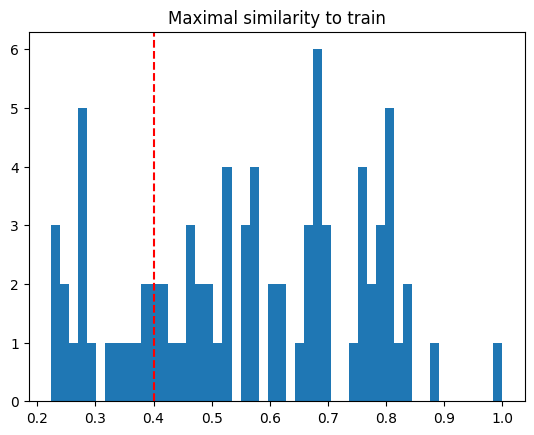

In [5]:
nearest_sim, nearest_idx = lohi.get_similar_mols(test_smiles, train_smiles, return_idx=True)
plt.hist(nearest_sim, bins=50)
plt.axvline(x=0.4, color = 'r', ls='--')
plt.title('Maximal similarity to train')

Using a random split will likely favor models that perform best on molecules similar to those in the training set, as most of the test molecules have a similarity score greater than 0.4 with the training set.

### Scaffold split

Some researchers argue that a scaffold split results in better and more meaningful dataset divisions.

If you encounter the error `ModuleNotFoundError: No module named 'tensorflow'`, eyou can either skip this step, trusting my word that it won't resolve the problem, or you can execute `pip install tensorflow`.

In [6]:
from deepchem.data import NumpyDataset
from deepchem.splits import ScaffoldSplitter
dataset = NumpyDataset(X=smiles, y=smiles, ids=smiles)
scaffold_splitter = ScaffoldSplitter()
train, test = scaffold_splitter.train_test_split(dataset)
train_smiles = train.ids
test_smiles = test.ids

2023-10-13 10:05:40.673921: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-13 10:05:40.675449: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 10:05:40.696073: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-13 10:05:40.696098: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-13 10:05:40.696110: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Text(0.5, 1.0, 'Maximal similarity to train')

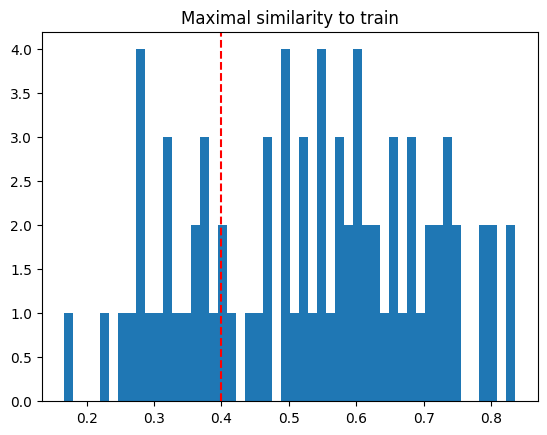

In [7]:
nearest_sim, nearest_idx = lohi.get_similar_mols(test_smiles, train_smiles, return_idx=True)
plt.hist(nearest_sim, bins=50)
plt.axvline(x=0.4, color = 'r', ls='--')
plt.title('Maximal similarity to train')

The problem is the same. Let's fix that.

## Hi Split, Train-Test
The Hi splitter divides the dataset into training and test sets in such a manner that no molecule in the test set is similar to any molecule in the training set. Occasionally, an exact split might not be feasible, leading to the discarding of some molecules. To minimize the number of discarded molecules, the Hi splitter implements the minimal vertex k-cut method.

In [8]:
smiles = drd2_hi['smiles'].to_list()

# Define a threshold for similarity. Molecules with a similarity score greater than 0.4 are considered similar.
similarity_threshold = 0.4

# Set proportions for the train and test sets.
train_min_frac = 0.7
test_min_frac = 0.1

# The combined fraction of train and test sets does not sum up to 1.0. This is because the splitter 
# might need to discard some molecules to achieve an approximate solution. In some cases, it's 
# challenging to partition the dataset precisely without excluding certain molecules. As a general 
# guideline, if the combined fractions are less than 1.0, the splitting process will be quicker, 
# but there's a possibility that more molecules will be discarded.

partition = lohi.hi_train_test_split(smiles, similarity_threshold, 
                                    train_min_frac, test_min_frac)


Total molecules in the giant component: 253.0
Min train size 177
Min test size 25
Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 3201 (-506) rows, 506 (0) columns and 6904 (-1012) elements
Clp1000I sum of infeasibilities 9.35496e-07 - average 2.92251e-10, 0 fixed columns
Coin0506I Presolve 3201 (0) rows, 506 (0) columns and 6904 (0) elements
Clp0029I End of values pass after 506 iterations
Clp0014I Perturbing problem by 0.001% of 1.0540599 - largest nonzero change 2.9990307e-05 ( 0.0014995153%) - largest zero change 0
Clp0000I Optimal - objective value 253
Clp0000I Optimal - objective value 253
Clp0000I Optimal - objective value 253
Coin0511I After Postsolve, objective 253, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 253 - 0 iterations time 0.082, Presolve 0.00, Idiot 0.08

Starting MIP optimization
Cgl0004I processed model has 3201

In [9]:
train_idx = partition[0]
test_idx = partition[1]

train_smiles = drd2_hi.iloc[train_idx]['smiles'].to_list()
test_smiles = drd2_hi.iloc[test_idx]['smiles'].to_list()

Text(0.5, 1.0, 'Maximal similarity to train')

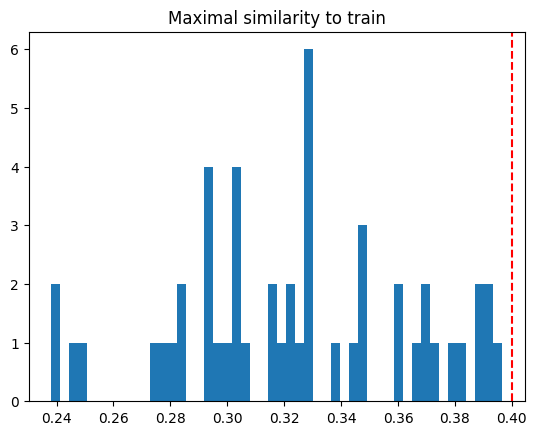

In [10]:
nearest_sim, nearest_idx = lohi.get_similar_mols(test_smiles, train_smiles, return_idx=True)
plt.hist(nearest_sim, bins=50)
plt.axvline(x=0.4, color = 'r', ls='--')
plt.title('Maximal similarity to train')

nice.

# Hi Split: k-fold
The Hi splitter can also partition the dataset into k equal parts, which can be useful for conducting k-fold cross-validation, especially with smaller datasets. 
Let's divide our data into three parts for 3-fold cross-validation.

In [11]:
smiles = drd2_hi['smiles'].to_list()
partition = lohi.hi_k_fold_split(smiles, similarity_threshold=0.4, k=3)

Total molecules in the giant component: 253.0
Min size of a partition: 75
Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 9853 (-759) rows, 759 (0) columns and 20712 (-1518) elements
Clp1000I sum of infeasibilities 0 - average 0, 0 fixed columns
Coin0506I Presolve 9853 (0) rows, 759 (0) columns and 20712 (0) elements
Clp0006I 0  Obj 225.3132 Dual inf 75899.999 (759)
Clp0029I End of values pass after 759 iterations
Clp0014I Perturbing problem by 0.001% of 1.0209197 - largest nonzero change 2.9973545e-05 ( 0.0014986773%) - largest zero change 2.982246e-05
Clp0000I Optimal - objective value 253
Clp0000I Optimal - objective value 253
Clp0000I Optimal - objective value 253
Coin0511I After Postsolve, objective 253, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 253 - 0 iterations time 0.422, Presolve 0.00, Idiot 0.41

Starting MIP optimization
Cgl0003I 0 fixed, 0 tightened bounds, 8904 strengthened rows, 0 substit

In [12]:
first_idx = partition[0]
second_idx = partition[1]
third_idx = partition[2]

first_smiles = drd2_hi.iloc[first_idx]['smiles'].to_list()
second_smiles = drd2_hi.iloc[second_idx]['smiles'].to_list()
third_smiles = drd2_hi.iloc[third_idx]['smiles'].to_list()

Text(0.5, 1.0, 'Maximal similarity between first and second')

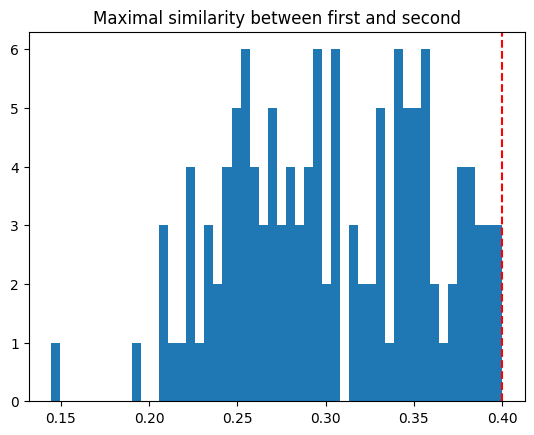

In [13]:
nearest_sim, nearest_idx = lohi.get_similar_mols(first_smiles, second_smiles, return_idx=True)
plt.hist(nearest_sim, bins=50)
plt.axvline(x=0.4, color = 'r', ls='--')
plt.title('Maximal similarity between first and second')

Text(0.5, 1.0, 'Maximal similarity between the second and the third')

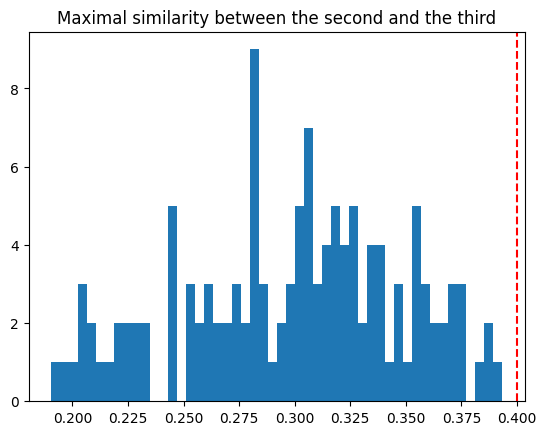

In [14]:
nearest_sim, nearest_idx = lohi.get_similar_mols(second_smiles, third_smiles, return_idx=True)
plt.hist(nearest_sim, bins=50)
plt.axvline(x=0.4, color = 'r', ls='--')
plt.title('Maximal similarity between the second and the third')

Text(0.5, 1.0, 'Maximal similarity between the third and the first')

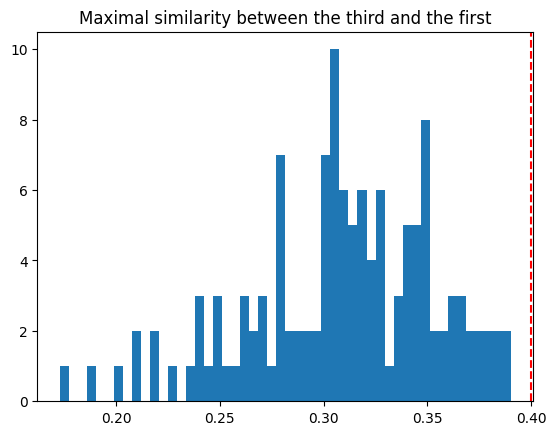

In [15]:
nearest_sim, nearest_idx = lohi.get_similar_mols(third_smiles, first_smiles, return_idx=True)
plt.hist(nearest_sim, bins=50)
plt.axvline(x=0.4, color = 'r', ls='--')
plt.title('Maximal similarity between the third and the first')